<a href="https://colab.research.google.com/github/Geovanasoliveira/Censo-Escolar-2024/blob/main/Case1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Script para tirar a pasta do zip direto no google drive
!pip install -q gdown
from google.colab import drive
drive.mount('/content/drive')
import gdown

# ID do arquivo ZIP
zip_file_id = "15jXMgNPBjeoW-cOEcEEEayyEq1seTHvZ"
zip_path = "/content/microdados_censo_escolar_2024.zip"

gdown.download(f"https://drive.google.com/uc?id={zip_file_id}", zip_path, quiet=False)

# Definir pasta de destino
dest_path = "/content/drive/MyDrive/censo_escolar"
import os
os.makedirs(dest_path, exist_ok=True)

# Extrair o ZIP diretamente para a pasta
!unzip -o "$zip_path" -d "$dest_path"

print(f"✅ Arquivo extraído para: {dest_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Downloading...
From (original): https://drive.google.com/uc?id=15jXMgNPBjeoW-cOEcEEEayyEq1seTHvZ
From (redirected): https://drive.google.com/uc?id=15jXMgNPBjeoW-cOEcEEEayyEq1seTHvZ&confirm=t&uuid=62bd8793-3a20-4fb8-ab8b-a0e1aaa0115c
To: /content/microdados_censo_escolar_2024.zip
100%|██████████| 30.5M/30.5M [00:00<00:00, 49.2MB/s]


Archive:  /content/microdados_censo_escolar_2024.zip
  inflating: /content/drive/MyDrive/censo_escolar/microdados_censo_escolar_2024/Anexos/ANEXO I - Dicionário de Dados/dicionário_dados_educação_básica.xlsx  
  inflating: /content/drive/MyDrive/censo_escolar/microdados_censo_escolar_2024/Anexos/ANEXO I - Dicionário de Dados/~$Dicionário de Dados da Educação Básica.xlsx  
  inflating: /content/drive/MyDrive/censo_escolar/microdados_censo_escolar_2024/Anexos/ANEXO I - Dicionário de Dados/~$dicionário_dados_educação_básica.xlsx  
  inflating: /content/drive/MyDrive/censo_escolar/microdados_censo_escolar_2024/Anexos/ANEXO II -  Questionários do Censo da Educação Basica/Aluno 2024.pdf  
  inflating: /content/drive/MyDrive/censo_escolar/microdados_censo_escolar_2024/Anexos/ANEXO II -  Questionários do Censo da Educação Basica/Escola 2024.pdf  
  inflating: /content/drive/MyDrive/censo_escolar/microdados_censo_escolar_2024/Anexos/ANEXO II -  Questionários do Censo da Educação Basica/Escola N

In [2]:
# Conectar Google Drive no Colab
from google.colab import drive
drive.mount('/content/drive')

# Manipulação de dados
import pandas as pd
import numpy as np

# Pré-processamento e modelagem
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Visualização
import matplotlib.pyplot as plt

Mounted at /content/drive


Duplicatas exatas removidas para treino: 18583
Silhouette (k=4) no conjunto sem duplicatas: 0.237


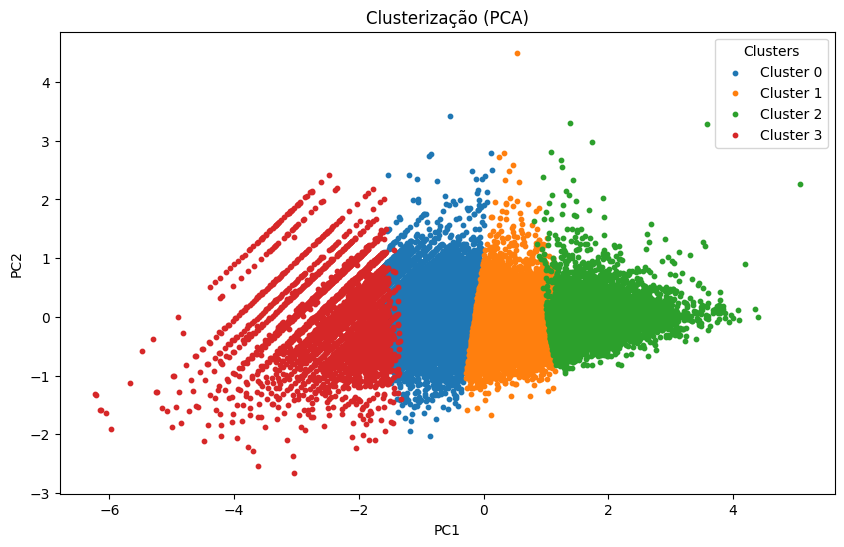


Médias por cluster (escala original):
         QT_MATRICULAS_TOTAL  QT_DOCENTE  IN_MATERIAL_PED_MULTIMIDIA  \
cluster                                                                
0                      140.9       15.64                        0.42   
1                     317.16       41.78                        0.62   
2                     936.45       90.68                        0.75   
3                      47.37        5.12                        0.39   

         IN_INTERNET  IN_LABORATORIO_CIENCIAS  
cluster                                        
0               0.99                     0.07  
1                1.0                     0.38  
2                1.0                     0.77  
3               0.98                     0.03  

Perfil médio por selo sugerido:
                      QT_MATRICULAS_TOTAL  QT_DOCENTE  \
Selo_Sugerido                                           
Kepler                              47.37        5.12   
Kepler / Compartilha                

In [10]:
csv_path = '/content/drive/MyDrive/censo_escolar/microdados_censo_escolar_2024/dados/microdados_ed_basica_2024.csv'

cols_minimas = [
    "TP_DEPENDENCIA", "TP_SITUACAO_FUNCIONAMENTO",
    "QT_MAT_BAS", "QT_MAT_MED",
    "IN_MATERIAL_PED_MULTIMIDIA", "IN_INTERNET", "IN_LABORATORIO_CIENCIAS",
    "QT_DOC_BAS", "QT_DOC_MED", "QT_DOC_FUND"
]

# dtypes mais econômicos (nullable) para reduzir uso de RAM
dtypes = {
    "TP_DEPENDENCIA": "Int8",
    "TP_SITUACAO_FUNCIONAMENTO": "Int8",
    "QT_MAT_BAS": "Int32",
    "QT_MAT_MED": "Int32",
    "IN_MATERIAL_PED_MULTIMIDIA": "Int8",
    "IN_INTERNET": "Int8",
    "IN_LABORATORIO_CIENCIAS": "Int8",
    "QT_DOC_BAS": "Int32",
    "QT_DOC_MED": "Int32",
    "QT_DOC_FUND": "Int32",
}

try:
    df = pd.read_csv(
        csv_path,
        usecols=cols_minimas,
        sep=';',
        encoding='latin1',
        dtype=dtypes,
        engine='pyarrow',
    )
except Exception:
    df = pd.read_csv(
        csv_path,
        usecols=cols_minimas,
        sep=';',
        encoding='latin1',
        dtype=dtypes,
        low_memory=False
    )

# Filtrar escolas privadas e ativas
df_privadas = df[
    (df["TP_DEPENDENCIA"] == 4) &
    (df["TP_SITUACAO_FUNCIONAMENTO"] == 1)
].copy()

# ---------------------------
# 2) Variáveis contínuas e binárias
# ---------------------------
df_privadas["QT_MATRICULAS_TOTAL"] = df_privadas["QT_MAT_BAS"].fillna(0) + df_privadas["QT_MAT_MED"].fillna(0)
df_privadas["QT_DOCENTE"] = (
    df_privadas["QT_DOC_BAS"].fillna(0) +
    df_privadas["QT_DOC_FUND"].fillna(0) +
    df_privadas["QT_DOC_MED"].fillna(0)
)

cont_features = ["QT_MATRICULAS_TOTAL", "QT_DOCENTE"]
bin_features  = ["IN_MATERIAL_PED_MULTIMIDIA", "IN_INTERNET", "IN_LABORATORIO_CIENCIAS"]
variaveis_cluster = cont_features + bin_features

df_cluster = df_privadas[variaveis_cluster].copy()

# Tratar faltantes
for col in cont_features:
    df_cluster[col] = df_cluster[col].fillna(0)
for col in bin_features:
    df_cluster[col] = df_cluster[col].fillna(0).clip(0, 1)

# Reduzir assimetria nas contínuas
df_cluster[cont_features] = np.log1p(df_cluster[cont_features])

# ---------------------------
# 3) Remover duplicatas para TREINO do modelo
# ---------------------------
df_sem_dup = df_cluster.drop_duplicates().copy()
print(f"Duplicatas exatas removidas para treino: {len(df_cluster) - len(df_sem_dup)}")

# ---------------------------
# 4) Pré-processamento e K-Means
# ---------------------------
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), cont_features),
        ("bin", "passthrough", bin_features)
    ],
    remainder="drop"
)

# Fit no conjunto sem duplicatas
X_train = preprocess.fit_transform(df_sem_dup)

k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels_train = kmeans.fit_predict(X_train)

sil = silhouette_score(X_train, labels_train)
print(f"Silhouette (k={k}) no conjunto sem duplicatas: {sil:.3f}")

# Prever clusters para TODAS as linhas (inclui duplicatas)
X_full = preprocess.transform(df_cluster)
labels_full = kmeans.predict(X_full)
df_privadas["cluster"] = labels_full

# ---------------------------
# 5) PCA para visualização com legenda
# ---------------------------
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train)

plt.figure(figsize=(10,6))

for cluster_id in range(k):
    mask = labels_train == cluster_id
    plt.scatter(
        X_train_pca[mask, 0],
        X_train_pca[mask, 1],
        s=10,
        label=f'Cluster {cluster_id}'
    )

plt.title('Clusterização (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title="Clusters")
plt.show()

# ===========================
# 6) Resumo das médias por cluster (base COMPLETA)
#    - contínuas no ESCALA ORIGINAL
# ===========================
# médias no original
medias_orig = (
    df_privadas.groupby("cluster")[cont_features + bin_features]
    .mean().round(2)
)
print("\nMédias por cluster (escala original):")
print(medias_orig)

# ===========================
# 7) Mapeamento automático Cluster → Selo
#    regra: usa um índice de “porte” = zscore(matrículas) + zscore(docentes)
#    e rankeia do menor pro maior para decidir o selo
# ===========================
stats = df_privadas.groupby("cluster")[["QT_MATRICULAS_TOTAL","QT_DOCENTE"]].mean()
z = (stats - stats.mean())/stats.std(ddof=0)
stats["porte_index"] = z["QT_MATRICULAS_TOTAL"] + z["QT_DOCENTE"]
# rank do menor (0) para maior (k-1)
rank_por_porte = stats["porte_index"].rank(method="first").astype(int) - 1

# cria um dicionário: cluster_id -> posição no rank
cluster_to_rank = rank_por_porte.to_dict()

# mapeamento por posição no rank
rank_to_selo = {
    0: "Kepler",                    # muito pequeno / popular
    1: "Kepler / Compartilha",      # pequeno–médio com alguma estrutura
    2: "Compartilha",               # médio com boa estrutura pedagógica
    3: "Uno / Farias Brito"         # grande, tecnológico e/ou alto desempenho
}

df_privadas["Selo_Sugerido"] = df_privadas["cluster"].map(lambda c: rank_to_selo[cluster_to_rank[c]])

# ===========================
# 8) Resumo por Selo (perfil médio)
# ===========================
perfil_selo = (
    df_privadas.groupby("Selo_Sugerido")[cont_features + bin_features]
    .mean().round(2)
).sort_values(by="QT_MATRICULAS_TOTAL")
print("\nPerfil médio por selo sugerido:")
print(perfil_selo)



In [26]:
# Percentis
percentis = [0.25, 0.75]

# Percentis matricula
percentis_matriculas = df_privadas["QT_MATRICULAS_TOTAL"].quantile([0.25, 0.75])

df_privadas['grupo_matriculas'] = pd.cut(
    df_privadas['QT_MATRICULAS_TOTAL'],
    bins=[-1, percentis_matriculas[0.25], percentis_matriculas[0.75], df_privadas['QT_MATRICULAS_TOTAL'].max()],
    labels=['Pequeno', 'Médio', 'Grande']
)

# Mostrar contagem por grupo de matriculas
print("\nContagem por grupo de matriculas:")
print(df_privadas['grupo_matriculas'].value_counts().sort_index())


# Percentis docentes
percentis_docentes = df_privadas["QT_DOCENTE"].quantile(percentis)

# Criar grupos para docentes

df_privadas['grupo_docentes'] = pd.cut(
    df_privadas['QT_DOCENTE'],
    bins=[
        -1,
        percentis_docentes[0.25],   # Limite Pequeno
        percentis_docentes[0.75],   # Limite Médio
        df_privadas['QT_DOCENTE'].max()
    ],
    labels=['Pequeno', 'Médio', 'Grande']
)


# Mostrar contagem por grupo de docentes
print("\nContagem por grupo de docentes:")
print(df_privadas['grupo_docentes'].value_counts().sort_index())



Contagem por grupo de matriculas:
grupo_matriculas
Pequeno    13279
Médio      26163
Grande     13126
Name: count, dtype: int64

Contagem por grupo de docentes:
grupo_docentes
Pequeno    13946
Médio      25928
Grande     12694
Name: count, dtype: int64


In [43]:
cols_analise = [
    'QT_MATRICULAS_TOTAL',
    'QT_DOCENTE',
    'IN_MATERIAL_PED_MULTIMIDIA',
    'IN_INTERNET',
    'IN_LABORATORIO_CIENCIAS'
]

describe_por_cluster = df_privadas.groupby('cluster')[cols_analise].describe().transpose()
display(describe_por_cluster)

cluster                                      0             1             2  \
QT_MATRICULAS_TOTAL        count  14633.000000   9215.000000   5226.000000   
                           mean     140.903711    317.160716    936.453884   
                           std       83.154812    179.852409    920.898060   
                           min       23.000000     61.000000    280.000000   
                           25%       94.000000    220.000000    570.000000   
                           50%      125.000000    292.000000    757.000000   
                           75%      168.000000    381.000000   1059.750000   
                           max     2341.000000  10435.000000  36822.000000   
QT_DOCENTE                 count  14633.000000   9215.000000   5226.000000   
                           mean      15.641290     41.780575     90.677191   
                           std        6.996915     14.204323     40.995158   
                           min        1.000000      1.000000      6.000000   
                           25%       10.000000     31.000000     66.000000   
                           50%       14.000000     40.000000     82.000000   
                           75%       20.000000     51.000000    104.000000   
                           max       54.000000    112.000000    512.000000   
IN_MATERIAL_PED_MULTIMIDIA count  14633.000000   9215.000000   5226.000000   
                           mean       0.418779      0.619099      0.754497   
                           std        0.493376      0.485635      0.430426   
                           min        0.000000      0.000000      0.000000   
                           25%        0.000000      0.000000      1.000000   
                           50%        0.000000      1.000000      1.000000   
                           75%        1.000000      1.000000      1.000000   
                           max        1.000000      1.000000      1.000000   
IN_INTERNET                count  14633.000000   9215.000000   5226.000000   
                           mean       0.992551      0.996961      0.999426   
                           std        0.085988      0.055042      0.023955   
                           min        0.000000      0.000000      0.000000   
                           25%        1.000000      1.000000      1.000000   
                           50%        1.000000      1.000000      1.000000   
                           75%        1.000000      1.000000      1.000000   
                           max        1.000000      1.000000      1.000000   
IN_LABORATORIO_CIENCIAS    count  14633.000000   9215.000000   5226.000000   
                           mean       0.074216      0.381552      0.767126   
                           std        0.262131      0.485794      0.422703   
                           min        0.000000      0.000000      0.000000   
                           25%        0.000000      0.000000      1.000000   
                           50%        0.000000      0.000000      1.000000   
                           75%        0.000000      1.000000      1.000000   
                           max        1.000000      1.000000      1.000000   

cluster                                      3  
QT_MATRICULAS_TOTAL        count  14144.000000  
                           mean      47.369344  
                           std       31.211683  
                           min        0.000000  
                           25%       25.000000  
                           50%       44.000000  
                           75%       65.000000  
                           max      390.000000  
QT_DOCENTE                 count  14144.000000  
                           mean       5.115809  
                           std        3.293384  
                           min        0.000000  
                           25%        3.000000  
                           50%        5.000000  
                           75%        7.000000  
                 

In [44]:
cols_analise = [
    'QT_MATRICULAS_TOTAL',
    'QT_DOCENTE',
    'IN_MATERIAL_PED_MULTIMIDIA',
    'IN_INTERNET',
    'IN_LABORATORIO_CIENCIAS'
]

# Calcula médias por cluster
medias_por_cluster = df_privadas.groupby('cluster')[cols_analise].mean().round(2)

print("📊 Médias por cluster:")
print(medias_por_cluster)

📊 Médias por cluster:
         QT_MATRICULAS_TOTAL  QT_DOCENTE  IN_MATERIAL_PED_MULTIMIDIA  \
cluster                                                                
0                     140.90       15.64                        0.42   
1                     317.16       41.78                        0.62   
2                     936.45       90.68                        0.75   
3                      47.37        5.12                        0.39   

         IN_INTERNET  IN_LABORATORIO_CIENCIAS  
cluster                                        
0               0.99                     0.07  
1               1.00                     0.38  
2               1.00                     0.77  
3               0.98                     0.03  
